## PLACEHOLDER
### Import data
The data we are importing is stored in a PostgreSQL database. This data is the review posts on yelp ranging from April 2005 till January 2013. Each post is identified by a review id. Each review id has a corrisponding user id for the user who posted it and business id for the business being posted about. Each post includes the cool , useful , and funny votes given by the community members. 

First we need to connect and retrieve this data from the database. We can import psycopg2 which is a PostgreSQL adapter for Python used to interegrate Python with PostgreSQL. We use it to connect to my personal database namd script on the local machine. Now we can execute commands to the database. We will do this using pandas to query for the table business and return the results in dataframe. A dataframe is essentially a data object in Python that allows manipulating of data in table form, with columns and rows. Let's first test it to see what the table looks like:

In [7]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
# Connect to personal database that contains Yelp.csv data as table business
conn = psycopg2.connect(host="localhost" , dbname="script", user="adam", password="Password")
#cursor = conn.cursor()
#cursor.execute("SELECT * FROM business")
#conn.commit()
# Read in table business and show first 5 lines 
test_query = pd.read_sql_query("SELECT * FROM business", conn)
test_query.head()

,bid,date,rid,star,texts,texttype,uid,cool,useful,funny
0,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
1,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
2,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
3,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
4,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,Rosie Dakota and I LOVE Chaparral Dog Park!!! ...,review,uZetl9T0NcROGOyFfughhg,1,2,0


## Understanding the Data
### Finding all unique columns

Some things of notice about the data is:
1. Some columns we might not need 
2. The heading seems to be in the first row 
3. It's not clear which IDs should we consider for insight

To solve #3 we should first find out how unique each column is. We do this by creating a list of both the column name and the percentage of values that are unique(0 to 1).

Our results how that review id is the only column that is completely unique with a ratio of 1. This means that every rid will reference 1 buid(business id) and 1 uid(user id) as it is impossible for any particular rid to repeat. This is oppose to bid and uid which both are only 40% and 60% unique respectively. This means we can use those two to learn more.

In [8]:
# Use list comprehention to grab all columns and use them to access each dataframe column values. 
# Then find the number of unique values and divide that number by the total number of rows
# Last put that value and the column name in a tuple and put all tuples in a list called unique
unique= [(i,(test_query[i].nunique())/len(test_query)) for i in test_query.columns]
# Turn list into a dataframe with data names as column 1 and unique length as column 2
pd.DataFrame.from_records(unique, columns=['data names' , 'unique length'])

,data names,unique length
0,bid,0.417458
1,date,0.199580
2,rid,1.000000
3,star,0.000600
4,texts,0.999800
5,texttype,0.000200
6,uid,0.640336
7,cool,0.003000
8,useful,0.002900
9,funny,0.003000


### Grouping users by the number of businesses they reviewed

So now we know business id and user id is the columns to look for. But which one do we want to be our main reference? Here user id was chosen because the users are the ones reviewing. 

Let's group users by the number of unique businesses they review and find the max , min , mean , and median. The lowest number of businesses a user reviews, not suprisingly, is 1. The highest is 38. The average number of businesses a user reviews 1.5 and the median is exactly 1. The median and mean being so similiar means there are no extreme outliers affecting the vaue.

If we sort the range of values and print specific rows we can show the top 10 and bottom 10. From this knowledge we can see the top 10 never repeat and grow in increasing increments , while the bottom 10 is just 1 in repeat. We can guess that other low values are probably just as common amd the high values are all different. This would be why despite such a large range the average number of businesses reviewed by a user sticks around 1. 

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
length_df = test_query.groupby('uid')[['bid']].nunique()
print('Max: {} , Min: {} , Mean: {} , Median: {}'.format(length_df['bid'].max(),length_df['bid'].min(), \
                                                         length_df['bid'].mean(),length_df['bid'].median()))
min_max_10 =pd.concat([length_df.sort_values(['bid'],ascending=False).head(10), \
              length_df.sort_values(['bid'],ascending=True).head(10)], keys=['Top 10', 'Bottom 10'])

min_max_10

Max: 38 , Min: 1 , Mean: 1.561680199875078 , Median: 1.0


bid
          uid                        
Top 10    fczQCSmaWF78toLEmb0Zsw   38
          0CMz8YaO3f8xu4KqQgKb9Q   25
          90a6z--_CUrl84aCzZyPsg   22
          4ozupHULqGyO42s3zNUzOQ   18
          0mqHhdKEdak_A1FBhFNXqA   18
          wHg1YkCzdZq9WBJOTRgxHQ   17
          0bNXP9quoJEgyVZu9ipGgQ   16
          _PzSNcfrCjeBxSLXRoMmgQ   16
          joIzw_aUiNvBTuGoytrH7g   15
          JgDkCER12uiv4lbpmkZ9VA   15
Bottom 10 zzmRKNph-pBHDL2qwGv9Fw    1
          ZmCfwDMuYkhpyr-hWKgiaw    1
          Zm2k6dJtqKDz3pZ70SwohA    1
          ZirtwB_QHFUGX_7x02jf5Q    1
          ZiMCaIaUlBmVnNjREY0W6Q    1
          Zi9UXJ81qMtzXRZ8mp7PxQ    1
          Zi0h5i-ZKDI9hZQgKCyDSw    1
          Zgp9T6IOVFOozrWDw_mUGQ    1
          vuxnLRJLT7EjjwIwycDAoA    1
          Zg_M3iwTqOgp-2i6Usyftg    1

### Distribution of grouping 

After creatingg a distribution plot our guess is justified. The mean is 1 which means just as much values are 1 that are in the range 2 to 38. So most users focus their attention on one business to review , probably inspired to create an account for that very reason. 

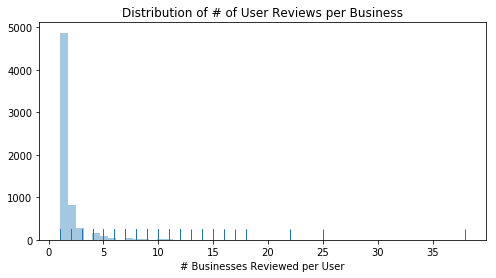

In [24]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.distplot(length_df['bid'],rug=True,kde=False,hist=True,ax=ax)
plt.xlabel('# Businesses Reviewed per User')
plt.title('Distribution of # of User Reviews per Business')
plt.show()

## PLACEHOLDER
### Querying for the right information



In [ ]:
df = pd.read_sql_query("SELECT date , star , texts, cool , useful, funny FROM business",conn)
yelp_df = pd.DataFrame(df).drop(df.index[0]).reset_index().drop(['index'] , axis=1)
print( yelp_df.info())
yelp_df.head()

In [ ]:
import seaborn as sns
%matplotlib inline
yelp_df['texts'].iloc[0]
print(yelp_df['star'].astype(int).describe())
#yelp_df['star'].astype(int).hist()
plt.show()
columns =  [ c for c in yelp_df.columns if c != 'date' and c !='texts' ]
for col in columns:
   yelp_df[col] = yelp_df[col].astype(int)
yelp_df.info()

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
''''groupedvalues=df.groupby('day').sum().reset_index()

pal = sns.color_palette("Greens_d", len(groupedvalues))
rank = groupedvalues["total_bill"].argsort().argsort() 
g=sns.barplot(x='day',y='tip',data=groupedvalues, palette=np.array(pal[::-1])[rank])

for index, row in groupedvalues.iterrows():
    g.text(row.name,row.tip, round(row.total_bill,2), color='black', ha="center")'''
#scaler = MinMaxScaler()
#sns.distplot(yelp_df['star'], kde=False)
sns.countplot(x ='star', data = yelp_df) 
#a = scaler.fit_transform(yelp_df['star'].value_counts().values.reshape(-1,1))
#star_graph = pd.Series([i for i in yelp_df['star'].value_counts()])
#star_graph.apply()
#sns.barplot(x=yelp_df['star'] , y=())
#list(a)
plt.show()

#a, b= np.unique(yelp_df['star'], return_counts=True)
#a,b

In [ ]:
#sns.barplot('star','cool', data = yelp_df) 
#sns.barplot('star','funny', data = yelp_df) 

#yelp_df['useful'] = yelp_df['useful'].astype(str) # Change value into category!!!
#yelp_df['cool'] = yelp_df['cool'].astype(str)
#yelp_df['star'] = yelp_df['star'].astype(str)
#groupby = yelp_df[['star','cool', 'useful']].groupby(['star','cool'], as_index=False).agg('count')
#yelp_df['cool'].value_counts()

''''embark_perc = titanic_df[["Embarked", "Survived"]].groupby(['Embarked'],as_index=False).mean()
sns.barplot(x='Embarked', y='Survived', data=embark_perc,order=['S','C','Q'],ax=axis'''
#pd.DataFrame(groupby).unstack(level=0).T.plot(kind='hbar')
#a = pd.DataFrame(groupby).unstack(level=1)#.iloc[:,1].plot(kind='bar')
#sns.barplot('cool','star',data=a)

#sns.barplot(a.index , 'star', data=a)



#cool transformation
top = (1/100)*(75*yelp_df['cool'].unique().max()+100*yelp_df['cool'].unique().min()-50*yelp_df['cool'].unique().min()) 
mid = (1/100)*(50*yelp_df['cool'].unique().max()+100*yelp_df['cool'].unique().min()-50*yelp_df['cool'].unique().min()) 
bottom = (1/100)*(25*yelp_df['cool'].unique().max()+100*yelp_df['cool'].unique().min()-50*yelp_df['cool'].unique().min())
#Useful Tranformation
top1 = (1/100)*(75*yelp_df['useful'].unique().max()+100*yelp_df['useful'].unique().min()-50*yelp_df['useful'].unique().min()) 
mid1 = (1/100)*(50*yelp_df['useful'].unique().max()+100*yelp_df['useful'].unique().min()-50*yelp_df['useful'].unique().min()) 
bottom1 = (1/100)*(25*yelp_df['useful'].unique().max()+100*yelp_df['useful'].unique().min()-50*yelp_df['useful'].unique().min())
# Funny Transformation
top2 = (1/100)*(75*yelp_df['funny'].unique().max()+100*yelp_df['funny'].unique().min()-50*yelp_df['funny'].unique().min()) 
mid2 = (1/100)*(50*yelp_df['funny'].unique().max()+100*yelp_df['funny'].unique().min()-50*yelp_df['funny'].unique().min()) 
bottom2 = (1/100)*(25*yelp_df['funny'].unique().max()+100*yelp_df['funny'].unique().min()-50*yelp_df['funny'].unique().min())
# Funny Transformation
#yelp_df['cool1'] = yelp_df['cool'].apply(lambda x: 'low' if x < bottom else 'high' if x > top else 'mid')

yelp_df['cool'] = yelp_df['cool'].apply(lambda x: 'Low' if x < bottom else 'High' if x > top else 'Middle')
yelp_df['useful'] = yelp_df['useful'].apply(lambda x: 0 if x < bottom1 else 2 if x > top1 else 1)
yelp_df['funny'] = yelp_df['funny'].apply(lambda x: 'Low' if x < bottom else 'High' if x > top else 'Middle')
np.unique(df['funny'] , return_counts=True)
#np.unique(yelp_df['cool1'] , return_counts=True) , np.unique(yelp_df['cool2'] , return_counts=True)

In [ ]:

g =sns.catplot(x ='funny',y='star',hue='useful', kind='bar',col='cool',ci=None,data = yelp_df, legend=False ) 
plt.legend(labels=['Low', 'Medium', 'High'], title='Usefulness', fancybox=True, fontsize='large')
#plt.xlabel('')
plt.subplots_adjust(top=0.8)
g.fig.suptitle('Yelp Comments-Average Stars by Funny / Cool Rating', fontsize=20)
plt.show()
#sns.catplot(x ='cool',y='star',hue='useful', kind='bar',data = yelp_df) 
#plt.show()